In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Load dataset
file_path = r"C:\Users\HP\Documents\data mining\XAUUSD H1.csv"
data = pd.read_csv(file_path)

# Add column names
data.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']

# Combine Date and Time into a single Datetime column
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

# Select relevant columns
data = data[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Set Datetime as index
data.set_index('Datetime', inplace=True)

# Drop rows with missing values
data.dropna(inplace=True)


In [3]:
# Calculate technical indicators
# Moving Averages
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()


In [4]:
# Moving Average Convergence Divergence (MACD)
short_window = 12
long_window = 26
signal_window = 9
data['EMA_12'] = data['Close'].ewm(span=short_window, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=long_window, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()


In [5]:

# Relative Strength Index (RSI)
def calculate_RSI(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    RS = avg_gain / avg_loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

data['RSI_14'] = calculate_RSI(data)


In [6]:
# Momentum
data['Momentum'] = data['Close'] - data['Close'].shift(10)


In [7]:
# Bollinger Bands
window = 20
data['BB_Middle'] = data['Close'].rolling(window=window).mean()
data['BB_Upper'] = data['BB_Middle'] + 2 * data['Close'].rolling(window=window).std()
data['BB_Lower'] = data['BB_Middle'] - 2 * data['Close'].rolling(window=window).std()


In [8]:
# Drop NaN values after calculations
data.dropna(inplace=True)

In [9]:
# Extract closing prices
prices = data['Close'].values.reshape(-1, 1)


In [10]:
# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(prices)


In [11]:
# Normalize technical indicators
indicators = data[['MA_10', 'MA_50', 'MACD', 'Signal_Line', 'RSI_14', 'Momentum', 'BB_Upper', 'BB_Lower']]
scaler_indicators = MinMaxScaler()
indicators_scaled = scaler_indicators.fit_transform(indicators)


In [12]:

# Combine scaled prices and indicators
data_scaled_with_indicators = np.hstack((data_scaled, indicators_scaled))


In [13]:
 #Create sequences
def create_sequences_with_indicators(data, sequence_length):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  # Target is the first column (scaled prices)
    return np.array(x), np.array(y)

sequence_length = 50
x, y = create_sequences_with_indicators(data_scaled_with_indicators, sequence_length)


In [14]:
# Split data into training and testing sets
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [15]:
# Build LSTM model
input_shape = (sequence_length, x_train.shape[-1])
model = Sequential([
    Input(shape=input_shape),
    LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)
])


optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')


In [16]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


In [17]:
# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/50
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 144s 65ms/step - loss: 0.4932 - val_loss: 0.1138 - learning_rate: 1.0000e-04
Epoch 2/50
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 158s 77ms/step - loss: 0.1527 - val_loss: 0.0957 - learning_rate: 1.0000e-04
Epoch 3/50
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 139s 68ms/step - loss: 0.0886 - val_loss: 0.0526 - learning_rate: 1.0000e-04
Epoch 4/50
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 148s 70ms/step - loss: 0.0468 - val_loss: 0.0259 - learning_rate: 1.0000e-04
Epoch 5/50
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 137s 67ms/step - loss: 0.0208 - val_loss: 0.0121 - learning_rate: 1.0000e-04
Epoch 6/50
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 131s 64ms/step - loss: 0.0092 - val_loss: 0.0067 - learning_rate: 1.0000e-04
Epoch 7/50
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 136s 66ms/step - loss: 0.0047 - val_loss: 0.0029 - learning_rate: 1.0000e-04
Epoch 8/50
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 158s 74ms/step - loss: 0.0031 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 9/50
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 196s 7

In [18]:

# Evaluate the model
loss = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")

512/512 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 1.0659e-04
Test Loss: 0.00011665002239169553


512/512 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step


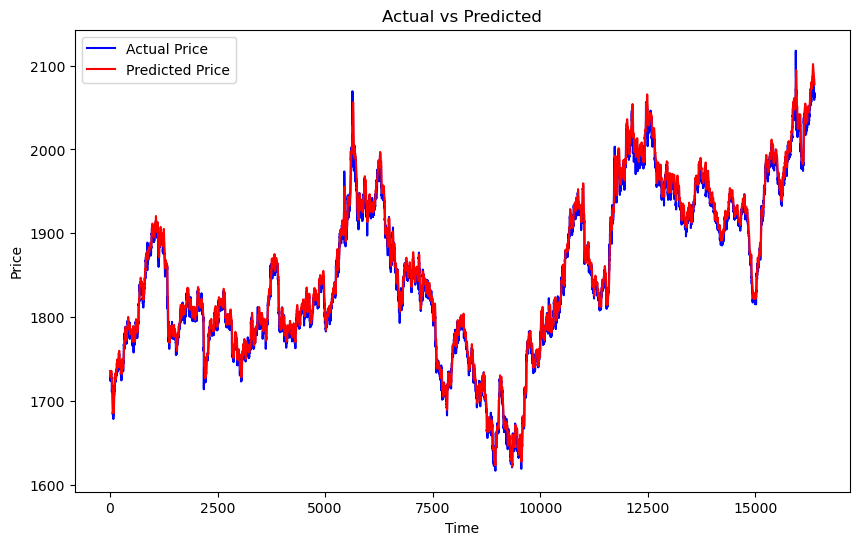

Mean Squared Error (MSE): 66.65339713186651
Mean Absolute Error (MAE): 6.201228652860021
R-squared (R²): 0.9929977046811319


In [19]:
# Validate the model
def validate_model(model, x_test, y_test, scaler):
    predictions = model.predict(x_test)
    predictions_rescaled = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Visualize predictions
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_rescaled, label="Actual Price", color="blue")
    plt.plot(predictions_rescaled, label="Predicted Price", color="red")
    plt.title("Actual vs Predicted")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    # Evaluate metrics
    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
    r2 = r2_score(y_test_rescaled, predictions_rescaled)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")

validate_model(model, x_test, y_test, scaler)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediksi Multi-Langkah: [[2076.944 ]
 [2046.0149]
 [1993.8265]
 [1929.3193]
 [1857.5583]
 [1782.8765]
 [1708.3597]
 [1636.0267]
 [1567.0726]
 [1502.0293]]


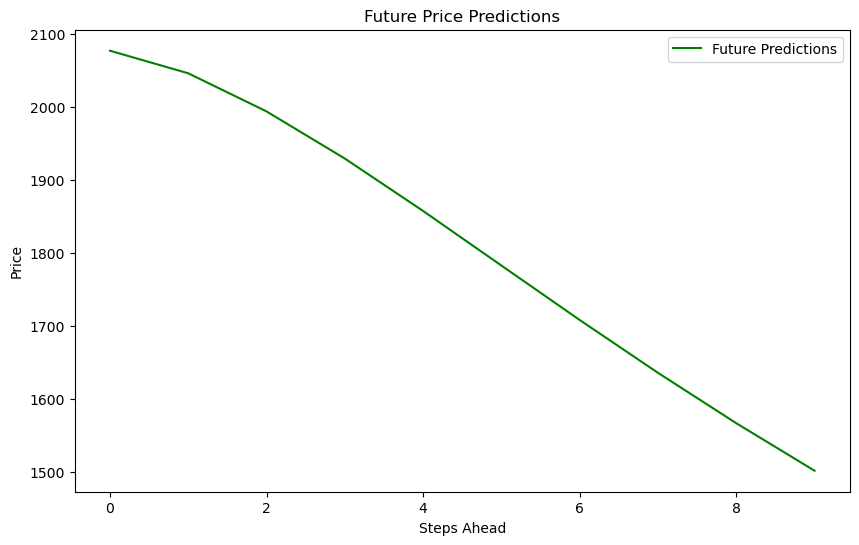

In [20]:
# Predict future prices
steps_ahead = 10
last_sequence = data_scaled_with_indicators[-sequence_length:]
last_sequence = np.expand_dims(last_sequence, axis=0)
future_predictions = []

for _ in range(steps_ahead):
    pred = model.predict(last_sequence)
    future_predictions.append(pred[0, 0])
    new_input = np.append(last_sequence[:, 1:, :], [[[pred[0, 0]] + [0]*(last_sequence.shape[2]-1)]], axis=1)
    last_sequence = new_input

# Transform predictions back to original scale
future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
print("Prediksi Multi-Langkah:", future_predictions_rescaled)

# Visualize future predictions
plt.figure(figsize=(10, 6))
plt.plot(future_predictions_rescaled, label="Future Predictions", color="green")
plt.title("Future Price Predictions")
plt.xlabel("Steps Ahead")
plt.ylabel("Price")
plt.legend()
plt.show()


In [21]:
# Save the model
model.save('my_model_with_indicators.keras')